# Dataset Preprocessing

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your original dataset
original_dataset_dir = 'dataset2'

# Define the path for the new dataset directory
new_dataset_dir = 'dataset3'

# Create the new dataset structure
os.makedirs(new_dataset_dir, exist_ok=True)
os.makedirs(os.path.join(new_dataset_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(new_dataset_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(new_dataset_dir, 'test'), exist_ok=True)

# Function to split data and copy files
def split_data(class_name):
    source_dir = os.path.join(original_dataset_dir, 'Training', class_name)
    train_dir = os.path.join(new_dataset_dir, 'train', class_name)
    val_dir = os.path.join(new_dataset_dir, 'val', class_name)
    
    # Create class directories in train and validation folders
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get all file names
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    
    # Split files into training and validation sets
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    # Copy training files to the new train directory
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    
    # Copy validation files to the new validation directory
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))

# Function to copy test data
def copy_test_data(class_name):
    source_dir = os.path.join(original_dataset_dir, 'Testing', class_name)
    target_dir = os.path.join(new_dataset_dir, 'test', class_name)
    os.makedirs(target_dir, exist_ok=True)
    
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    for file in files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

# List of classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Apply functions to each class
for class_name in classes:
    split_data(class_name)
    copy_test_data(class_name)

print("Dataset successfully split and copied to new structure!")


Dataset successfully split and copied to new structure!


# Dataset Visualizations

Dataset Distribution:
glioma - Train: 1056, Validation: 265, Test: 300
meningioma - Train: 1071, Validation: 268, Test: 307
notumor - Train: 1276, Validation: 319, Test: 405
pituitary - Train: 1165, Validation: 292, Test: 300


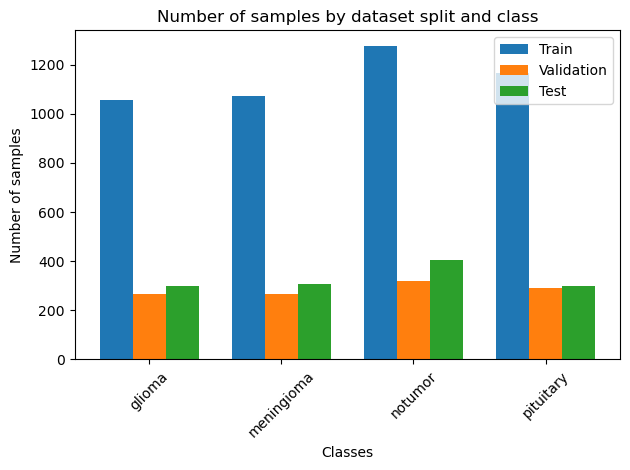

In [3]:
import os
import matplotlib.pyplot as plt

# Initialize dictionaries to count the number of files in each split
train_counts = {}
val_counts = {}
test_counts = {}

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
new_dataset_dir = 'dataset3'

# Count files in each directory
for class_name in classes:
    train_dir = os.path.join(new_dataset_dir, 'train', class_name)
    val_dir = os.path.join(new_dataset_dir, 'val', class_name)
    test_dir = os.path.join(new_dataset_dir, 'test', class_name)

    train_counts[class_name] = len([name for name in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, name))])
    val_counts[class_name] = len([name for name in os.listdir(val_dir) if os.path.isfile(os.path.join(val_dir, name))])
    test_counts[class_name] = len([name for name in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, name))])

# Print the numbers for each class and split
print("Dataset Distribution:")
for class_name in classes:
    print(f"{class_name} - Train: {train_counts[class_name]}, Validation: {val_counts[class_name]}, Test: {test_counts[class_name]}")

# Prepare data for plotting
labels = classes
train_values = [train_counts[class_name] for class_name in classes]
val_values = [val_counts[class_name] for class_name in classes]
test_values = [test_counts[class_name] for class_name in classes]

x = range(len(labels))  # the label locations

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(x, train_values, width=0.25, label='Train', align='center')
ax.bar([p + 0.25 for p in x], val_values, width=0.25, label='Validation', align='center')
ax.bar([p + 0.5 for p in x], test_values, width=0.25, label='Test', align='center')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples by dataset split and class')
ax.set_xticks([p + 0.25 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Rotate the tick labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Training a ViT

In [4]:
# install dependencies
!pip install torch torchvision timm

Defaulting to user installation because normal site-packages is not writeable


In [5]:
dataset_name = "dataset3"

In [6]:
# Creating data loaders

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to fit the ViT model input
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(f'{dataset_name}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{dataset_name}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{dataset_name}/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Initialize ViT
import timm
import torch.nn as nn

# Load a pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))

# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    break

print(outputs.shape)
print(outputs[0])

torch.Size([32, 4])
tensor([-2.0399,  0.4690,  2.7036, -3.4871], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    model.train()
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward
            loss.backward()
            # Optimize
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy}%')
        model.train()

    return train_accuracies, val_accuracies, train_losses, val_losses

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20)

Epoch 1, Train Loss: 1.5219, Train Accuracy: 40.71803852889667%, Val Loss: 1.2597, Val Accuracy: 44.23076923076923%
Epoch 2, Train Loss: 1.0995, Train Accuracy: 54.13747810858143%, Val Loss: 1.0258, Val Accuracy: 60.05244755244755%
Epoch 3, Train Loss: 0.9698, Train Accuracy: 60.923817863397545%, Val Loss: 1.1271, Val Accuracy: 48.86363636363637%
Epoch 4, Train Loss: 0.8674, Train Accuracy: 65.43345008756567%, Val Loss: 0.7843, Val Accuracy: 68.00699300699301%
Epoch 5, Train Loss: 0.8066, Train Accuracy: 68.78283712784588%, Val Loss: 0.7203, Val Accuracy: 71.15384615384616%
Epoch 6, Train Loss: 0.7437, Train Accuracy: 71.43169877408056%, Val Loss: 0.7162, Val Accuracy: 72.37762237762237%
Epoch 7, Train Loss: 0.7409, Train Accuracy: 71.34413309982487%, Val Loss: 0.6349, Val Accuracy: 75.0%
Epoch 8, Train Loss: 0.6856, Train Accuracy: 74.21190893169877%, Val Loss: 0.6480, Val Accuracy: 74.2132867132867%
Epoch 9, Train Loss: 0.6648, Train Accuracy: 74.43082311733801%, Val Loss: 0.6634, Va

In [13]:
def plot_accuracies(train_metric, val_metric, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label=f'Training {metric_name}')
    plt.plot(val_accuracies, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


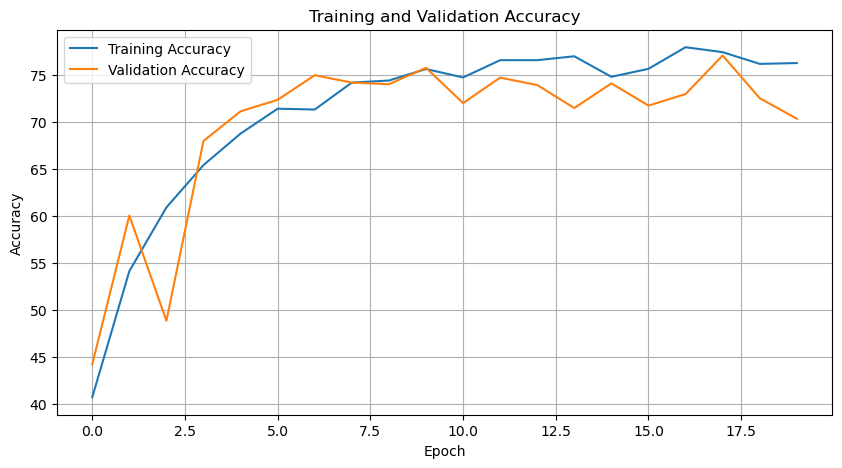

In [14]:
# Plot the accuracies
plot_accuracies(train_accuracies, val_accuracies, "Accuracy")

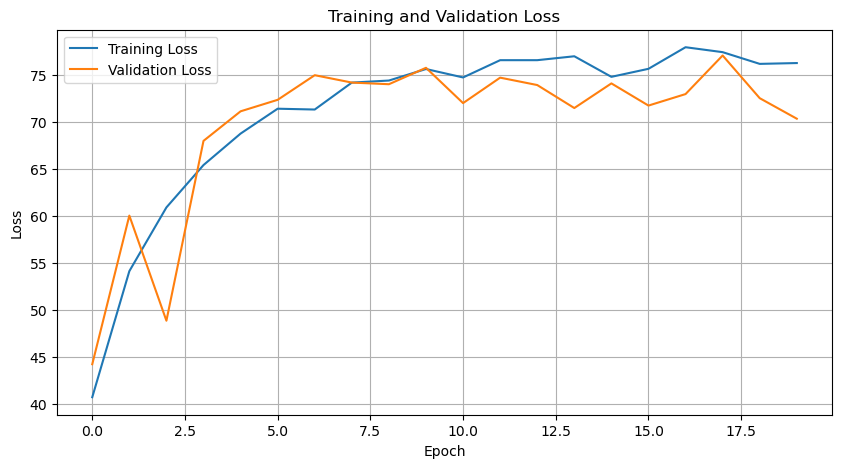

In [15]:
plot_accuracies(train_losses, val_losses, "Loss")

In [16]:
torch.save(model.state_dict(), 'vit_image_classifier.pth')

In [17]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Call the test model function (Assuming 'model' and 'test_loader' are already defined and initialized)
test_accuracy = test_model(model, test_loader, device)


Test Accuracy: 69.93%


In [18]:
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    # If you also want to include non-trainable parameters, you can remove the condition `if p.requires_grad`
    total_all_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters (including non-trainable): {total_all_params}")

# Example of using the function with your model
print_model_parameters(model)

Total trainable parameters: 85801732
Total parameters (including non-trainable): 85801732


### Visualizing a ViT

In [21]:
!pip install torchviz

Defaulting to user installation because normal site-packages is not writeable


In [22]:
import torch
from torchviz import make_dot

# Create a dummy input tensor (batch size, channels, height, width)
dummy_input = torch.randn(1, 3, 224, 224)

# Assume 'model' is already defined and imported
# Move the model and input to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = dummy_input.to(device)
model = model.to(device)

# Forward pass through the model
outputs = model(dummy_input)

# Generate the computation graph
graph = make_dot(outputs, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))

# Render and display the graph
graph.render('vit_computation_graph', format='png', cleanup=True)  # Saves the graph as 'vit_computation_graph.png'
graph.view()  # Opens the graph image in the default viewer


'vit_computation_graph.pdf'

/usr/bin/xdg-open: line 862: www-browser: command not found
/usr/bin/xdg-open: line 862: links2: command not found
/usr/bin/xdg-open: line 862: elinks: command not found
/usr/bin/xdg-open: line 862: links: command not found
/usr/bin/xdg-open: line 862: lynx: command not found
/usr/bin/xdg-open: line 862: w3m: command not found
xdg-open: no method available for opening 'vit_computation_graph.pdf'


## Parameter Count

# Training a CNN

In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_name = "dataset3"

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Load datasets
train_dataset = datasets.ImageFolder(f'{dataset_name}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{dataset_name}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{dataset_name}/test', transform= transform)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Change to 3 if you use RGB images
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Adjust size according to your input image size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = SimpleCNN()

In [18]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%')

    return train_accuracies, train_losses, val_accuracies, val_losses


# Train the model and get performance metrics
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x20736 and 50176x128)

In [ ]:
# save model


In [20]:
# plot losses

In [21]:
def test_accuracy(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed for testing, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Assuming test_loader is defined and the model is already trained
test_accuracy = test_accuracy(model, test_loader)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x20736 and 50176x128)

# Saleincy Maps on CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_saliency(model, images, labels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    images, labels = images.to(device), labels.to(device)
    images.requires_grad_()

    model.eval()
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Saliency is the absolute value of the gradient
    saliency, _ = torch.max(images.grad.data.abs(), dim=1)
    saliency = saliency.reshape(images.shape[0], 28, 28)  # Reshape to match the size of the input images

    # Plot the images and their saliencies
    fig, ax = plt.subplots(2, len(images), figsize=(12, 4))
    for i in range(len(images)):
        ax[0, i].imshow(images[i].detach().cpu().squeeze(), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(saliency[i].cpu(), cmap='hot')
        ax[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have some test images and labels loaded)
images, labels = next(iter(test_loader))  # Load a batch of test images and labels
visualize_saliency(model, images, labels)


## Parameter Count

# GradCAM